In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/coffee-bean-tanvir/Coffee Bean.csv
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (2).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (95).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (45).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (8).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (83).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (15).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (98).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (91).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (22).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (23).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (75).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (55).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (11).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (39).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (100).png
/kaggle/input/coffee-bean-tanvir/test/Dark/dark (33).png
/kaggle/input/coffee-bean-tanvir/test/Da

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time

import tensorflow as tf
from tensorflow.keras import layers, models, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.preprocessing import LabelEncoder, StandardScaler, label_binarize
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.neighbors import KNeighborsClassifier

2025-08-27 16:27:57.237756: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756312077.432691      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756312077.480930      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
base_dir = "/kaggle/input/coffee-bean-tanvir"

def create_dataframe(data_dir):
    file_paths = []
    labels = []
    for class_name in os.listdir(data_dir):
        class_dir = os.path.join(data_dir, class_name)
        if not os.path.isdir(class_dir):
            continue
        for image_name in os.listdir(class_dir):
            file_paths.append(os.path.join(class_dir, image_name))
            labels.append(class_name)
    df = pd.DataFrame({"file_path": file_paths, "label": labels})
    return df.sample(frac=1).reset_index(drop=True)

train_df = create_dataframe(os.path.join(base_dir, "train"))
test_df = create_dataframe(os.path.join(base_dir, "test"))

print(train_df.head())
print(test_df.head())

                                           file_path  label
0  /kaggle/input/coffee-bean-tanvir/train/Dark/da...   Dark
1  /kaggle/input/coffee-bean-tanvir/train/Green/g...  Green
2  /kaggle/input/coffee-bean-tanvir/train/Dark/da...   Dark
3  /kaggle/input/coffee-bean-tanvir/train/Dark/da...   Dark
4  /kaggle/input/coffee-bean-tanvir/train/Dark/da...   Dark
                                           file_path  label
0  /kaggle/input/coffee-bean-tanvir/test/Dark/dar...   Dark
1  /kaggle/input/coffee-bean-tanvir/test/Dark/dar...   Dark
2  /kaggle/input/coffee-bean-tanvir/test/Light/li...  Light
3  /kaggle/input/coffee-bean-tanvir/test/Green/gr...  Green
4  /kaggle/input/coffee-bean-tanvir/test/Dark/dar...   Dark


In [4]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='file_path',
    y_col='label',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='file_path',
    y_col='label',
    target_size=(128,128),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print("Number of classes:", num_classes)

Found 1200 validated image filenames belonging to 4 classes.
Found 400 validated image filenames belonging to 4 classes.
Number of classes: 4


In [5]:
from tensorflow.keras.layers import Layer

class SelfAttention(Layer):
    def __init__(self, channels):
        super(SelfAttention, self).__init__()
        self.channels = channels

    def build(self, input_shape):
        self.f_conv = layers.Conv2D(self.channels//8, 1, padding='same')
        self.g_conv = layers.Conv2D(self.channels//8, 1, padding='same')
        self.h_conv = layers.Conv2D(self.channels, 1, padding='same')
        super(SelfAttention, self).build(input_shape)

    def call(self, x):
        f = self.f_conv(x)
        g = self.g_conv(x)
        h = self.h_conv(x)

        f_flat = tf.reshape(f, [tf.shape(x)[0], -1, self.channels//8])
        g_flat = tf.reshape(g, [tf.shape(x)[0], -1, self.channels//8])
        h_flat = tf.reshape(h, [tf.shape(x)[0], -1, self.channels])

        s = tf.matmul(g_flat, f_flat, transpose_b=True)
        beta = tf.nn.softmax(s, axis=-1)
        o = tf.matmul(beta, h_flat)
        o = tf.reshape(o, tf.shape(x))  # reshape to original input shape
        out = x + o
        return out

In [6]:
def build_attention_cnn(input_shape=(128,128,3), num_classes=4):
    inputs = Input(shape=input_shape)
    
    x = layers.Conv2D(32, (3,3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2,2))(x)
    x = SelfAttention(32)(x)
    
    x = layers.Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = SelfAttention(64)(x)
    
    x = layers.Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2,2))(x)
    x = SelfAttention(128)(x)
    
    x = layers.Flatten()(x)
    x = layers.Dense(256, activation='relu')(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    
    model = models.Model(inputs, outputs)
    return model

model = build_attention_cnn(num_classes=num_classes)
model.summary()

I0000 00:00:1756312091.803346      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention (SelfAttention)  │ (None, 64, 64, 32)     │         1,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_1                │ (None, 32, 32, 64)     │         5,200 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ self_attention_2                │ (None, 16, 16, 128)    │        20,640 │
│ (SelfAttention)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     8,388,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,510,300 (32.46 MB)

 Trainable params: 8,510,300 (32.46 MB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

EPOCHS = 20

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=test_generator
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1756312100.577536      59 service.cc:148] XLA service 0x78b12c0179f0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756312100.578353      59 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1756312101.235405      59 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1756312108.313164      59 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


38/38 ━━━━━━━━━━━━━━━━━━━━ 38s 624ms/step - accuracy: 0.2921 - loss: 2.3195 - val_accuracy: 0.3300 - val_loss: 1.2487
Epoch 2/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 236ms/step - accuracy: 0.5367 - loss: 1.0003 - val_accuracy: 0.8950 - val_loss: 0.3430
Epoch 3/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.8667 - loss: 0.3842 - val_accuracy: 0.9500 - val_loss: 0.1628
Epoch 4/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.9069 - loss: 0.2428 - val_accuracy: 0.9400 - val_loss: 0.1886
Epoch 5/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 234ms/step - accuracy: 0.9616 - loss: 0.1129 - val_accuracy: 0.9625 - val_loss: 0.1308
Epoch 6/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.9719 - loss: 0.1010 - val_accuracy: 0.9625 - val_loss: 0.1194
Epoch 7/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 232ms/step - accuracy: 0.9287 - loss: 0.1870 - val_accuracy: 0.9600 - val_loss: 0.1262
Epoch 8/20
38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 230ms/step - accuracy: 0.9674 - loss: 0.0976 - val_accuracy: 0.9700 - val

In [8]:
# Remove last dense layer
feature_extractor = models.Model(inputs=model.input, outputs=model.layers[-3].output)  # last Flatten layer before Dense

# Extract features
def extract_features(generator, feature_model):
    features = feature_model.predict(generator, verbose=1)
    labels = generator.classes
    return features, labels

X_train_features, y_train_labels = extract_features(train_generator, feature_extractor)
X_test_features, y_test_labels = extract_features(test_generator, feature_extractor)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

38/38 ━━━━━━━━━━━━━━━━━━━━ 9s 202ms/step
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step


In [9]:
# Initialize and train a KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors=5) # You can adjust n_neighbors
knn_model.fit(X_train_scaled, y_train_labels)

KNeighborsClassifier()

Accuracy: 0.21
Precision: 0.20951650688492793
Recall: 0.21
F1-score: 0.20490604130759857
Confusion Matrix:
 [[26 18 33 23]
 [40 17 31 12]
 [45 17 29  9]
 [21 43 24 12]]


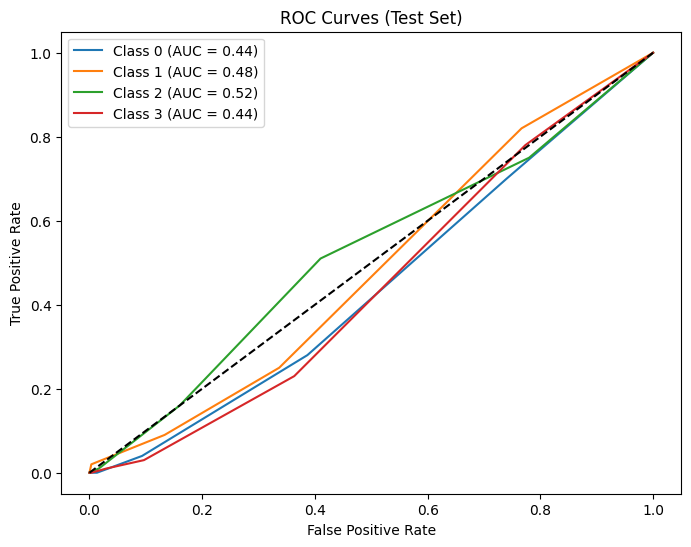

Test AUC: 0.4733333333333333


In [10]:
# ---- Predictions ----
y_test_pred = knn_model.predict(X_test_scaled)
y_test_proba = knn_model.predict_proba(X_test_scaled)

# ---- Basic Metrics ----
print("Accuracy:", accuracy_score(y_test_labels, y_test_pred))
print("Precision:", precision_score(y_test_labels, y_test_pred, average='macro'))
print("Recall:", recall_score(y_test_labels, y_test_pred, average='macro'))
print("F1-score:", f1_score(y_test_labels, y_test_pred, average='macro'))
print("Confusion Matrix:\n", confusion_matrix(y_test_labels, y_test_pred))

# ---- ROC-AUC Curves ----
# Binarize labels for multi-class ROC
classes_present = np.unique(y_test_labels)
y_test_bin = label_binarize(y_test_labels, classes=classes_present)

# Only plot ROC if at least 2 classes are present
if y_test_bin.shape[1] > 1:
    plt.figure(figsize=(8,6))
    for i in range(y_test_bin.shape[1]):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_test_proba[:, i])
        plt.plot(fpr, tpr, label=f"Class {classes_present[i]} (AUC = {auc(fpr, tpr):.2f})")
    plt.plot([0,1],[0,1],'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curves (Test Set)")
    plt.legend()
    plt.show()

    # Compute overall ROC-AUC
    print("Test AUC:", roc_auc_score(y_test_bin, y_test_proba, multi_class='ovr'))
else:
    print("ROC-AUC skipped: less than 2 classes present in test set")